In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import re

import glob
import os.path

# import sys
# from paths import Paths
# paths = Paths()
# sys.path.append(paths.scripts_root)
# import util

#import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#paths.print_paths()

### Helper Functions

In [2]:
def readRaw(filepath, rows, cols):
    try: 
        with open(filepath, 'rb') as fd:
            raw_buf = np.fromfile(fd, dtype=np.uint8, count=rows*cols)
        #raw_buf = 255-raw_buf
        return raw_buf.reshape((rows, cols)) #notice row, column format
    except FileNotFoundError:
        print("Error! File not found: %s" % (filepath))
        raise

def plot_imgs(img_data_lst, color=False, interp='none', max_cols=3, fig_size=10):
    cnt=len(img_data_lst)
    r,c,n = cnt,cnt,1
    for idx, img_data in enumerate(img_data_lst):
        if idx % max_cols == 0:
            plt.figure(figsize=(fig_size*r,fig_size*c))
        plt.subplot(r,c,idx+1)
        if color:
            #plt.imshow(img_data[0], interpolation='none', vmax=abs(img_data[0]).max(), vmin=-abs(img_data[0]).max())
            plt.imshow(img_data[0].astype(np.float), interpolation=interp)
        else:
            plt.imshow(img_data[0].astype(np.float), interpolation=interp, cmap='gray')
        plt.title('%s' % (img_data[1])), plt.xticks([]), plt.yticks([])


In [150]:
folder_root = "/Users/trafferty/tmp/extrusion_images"

good_samples = [
    ('request_3', 3, 'jig: filled 2 adjacent fields'),
    ('raw', 5, 'jig: filled'),
]
sample = good_samples[1]

_type = 'raw'
f=18

if _type == 'raw':
    dark_root   = "%s/RawImages_Dark" % (folder_root)
    bright_root = "%s/RawImages_Bright" % (folder_root)
    suffix = 'B1-IP_OAS'
elif _type == 'request_1':
    dark_root   = "%s/request1_dark" % (folder_root)
    bright_root = "%s/request1_bright" % (folder_root)
    suffix = 'A2-IP_OAS'
elif _type == 'request_2':
    dark_root   = "%s/request2_dark" % (folder_root)
    bright_root = "%s/request2_bright" % (folder_root)
    suffix = 'A2-IP_OAS'
elif _type == 'request_3':
    dark_root   = "%s/request3_bare_dark" % (folder_root)
    bright_root = "%s/request3_bare_bright" % (folder_root)
    suffix = 'A2-IP_OAS'

DF_glob_filespec = "%s/*.raw" % (dark_root)
BF_glob_filespec = "%s/*.raw" % (bright_root)

DF_paths = glob.glob(DF_glob_filespec)
DF_files = [os.path.basename(path) for path in DF_paths ]
BF_paths = glob.glob(BF_glob_filespec)
BF_files = [os.path.basename(path) for path in BF_paths ]

regex = r"%s-[0-9_+]*-w1-p1-sna-f%d-1r[0-9]-[0-9r]*-2048x1088.raw" % (suffix, f)

dark_path = ''
bright_path = ''

for DF_path in DF_paths:
    DF_match = re.search(regex, DF_path)
    if DF_match:
        for BF_path in BF_paths:
            BF_match = re.search(regex, BF_path)
            if BF_match:
                dark_path = DF_path 
                bright_path = BF_path
print("Darkfield file:   " , os.path.basename(dark_path))
print("Brightfield file: " , os.path.basename(bright_path))

Darkfield file:    B1-IP_OAS-20171018_134223_742942+0900-w1-p1-sna-f18-1r0-2r62789-2048x1088.raw
Brightfield file:  B1-IP_OAS-20171018_133905_437590+0900-w1-p1-sna-f18-1r0-2r60098-2048x1088.raw


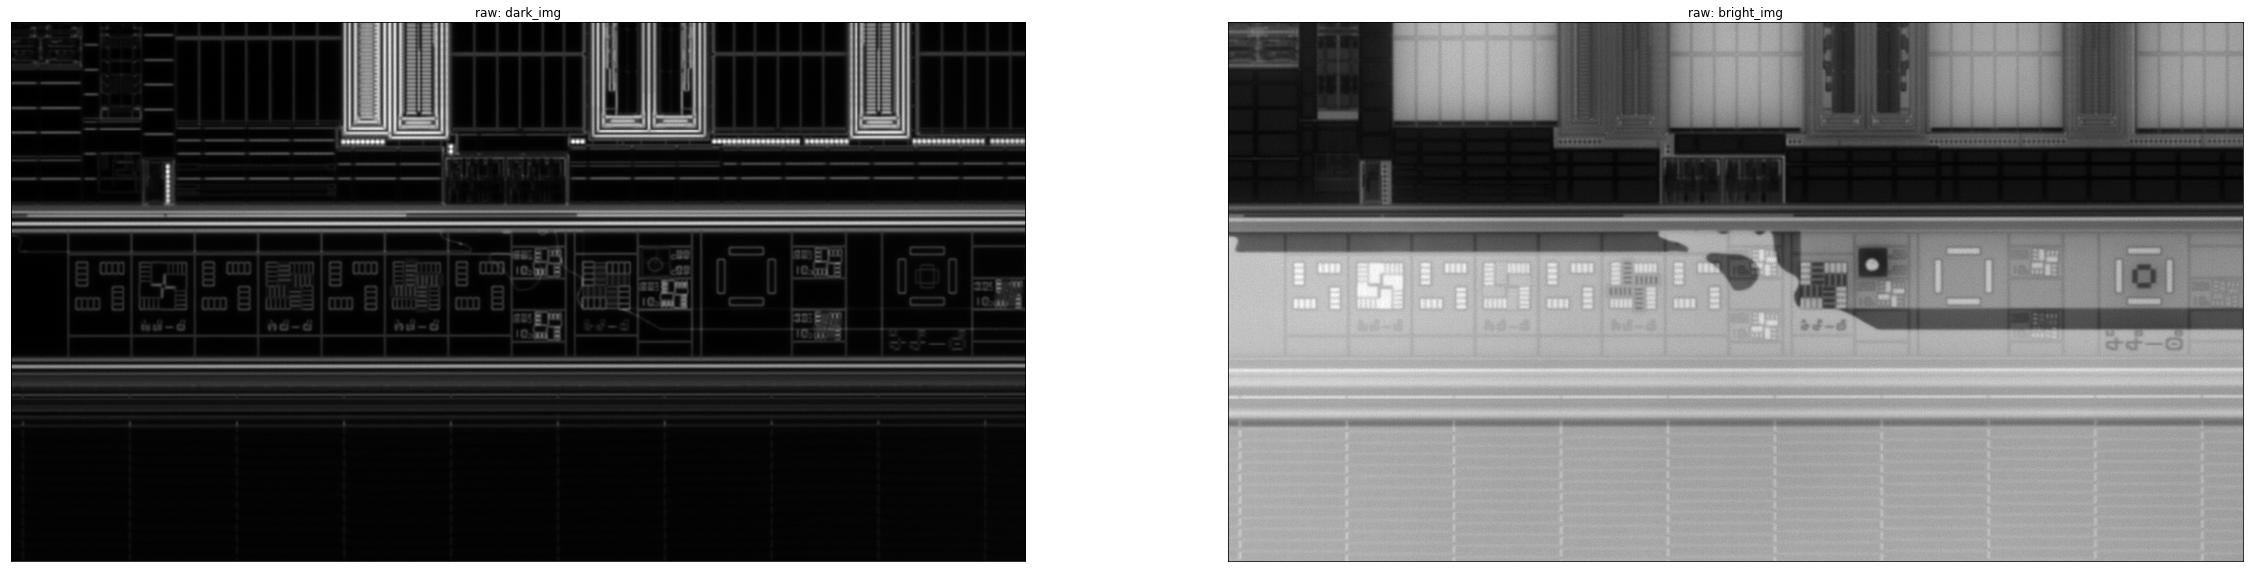

In [151]:

raw_rows = 1088
raw_cols = 2048
dark_img = readRaw(dark_path, raw_rows, raw_cols)
bright_img = readRaw(bright_path, raw_rows, raw_cols)

plot_imgs([(dark_img,'%s: dark_img' % (_type)), (bright_img,'%s: bright_img' % (_type))], max_cols = 2, fig_size = 20)

#/Users/trafferty/tmp/extrusion_images/00403858_180514_SFC_DeviceZ_Dark/-58_-15725/Field_4_-58_-15725.raw

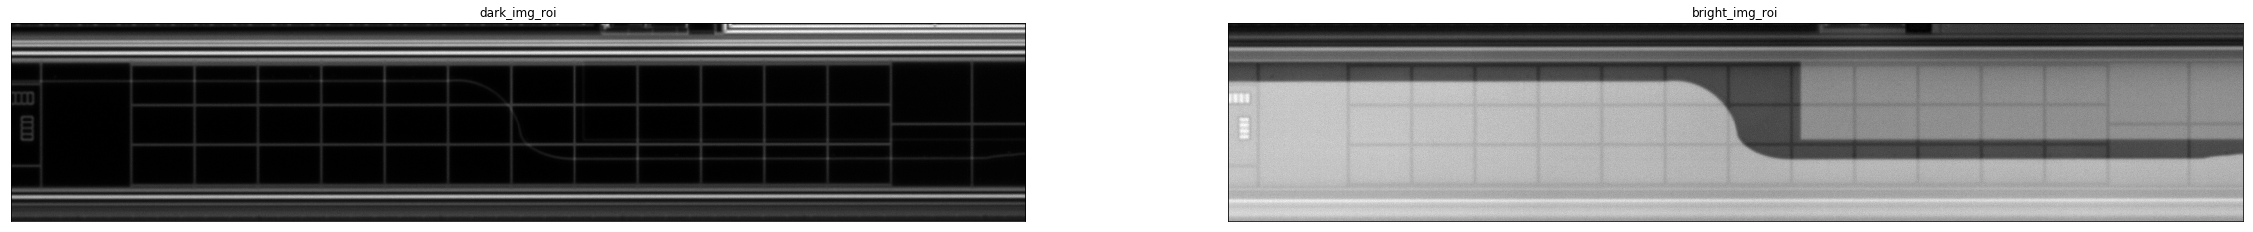

In [139]:
rows, cols = dark_img.shape
midX, midY = int(cols/2), int(rows/2)

height = 400
width  = cols
offsetX = 0
offsetY = 0
Y = midY+offsetY
X = midX+offsetX
startY = int(Y - (height/2))
endY   = int(Y + (height/2))
startX = int(X - (width/2))
endX   = int(X + (width/2))

dark_img_roi = dark_img[startY:endY, startX:endX]
bright_img_roi = bright_img[startY:endY, startX:endX]

plot_imgs([(dark_img_roi,'dark_img_roi'), (bright_img_roi,'bright_img_roi')], max_cols = 2, fig_size = 20)

Delta value: 199


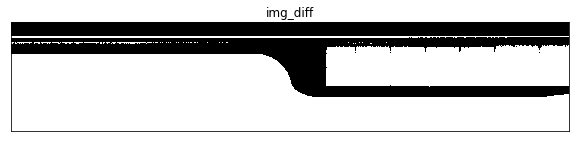

In [140]:
img_diff = cv2.absdiff(dark_img_roi, bright_img_roi)

delta_value = img_diff.max() - img_diff.min()
print("Delta value: %d" % delta_value)

img_bin = bright_img_roi > img_diff.mean()


plot_imgs([(img_bin,'img_bin')], max_cols = 2, fig_size = 10)

In [141]:
from skimage import feature
from skimage.transform import hough_circle

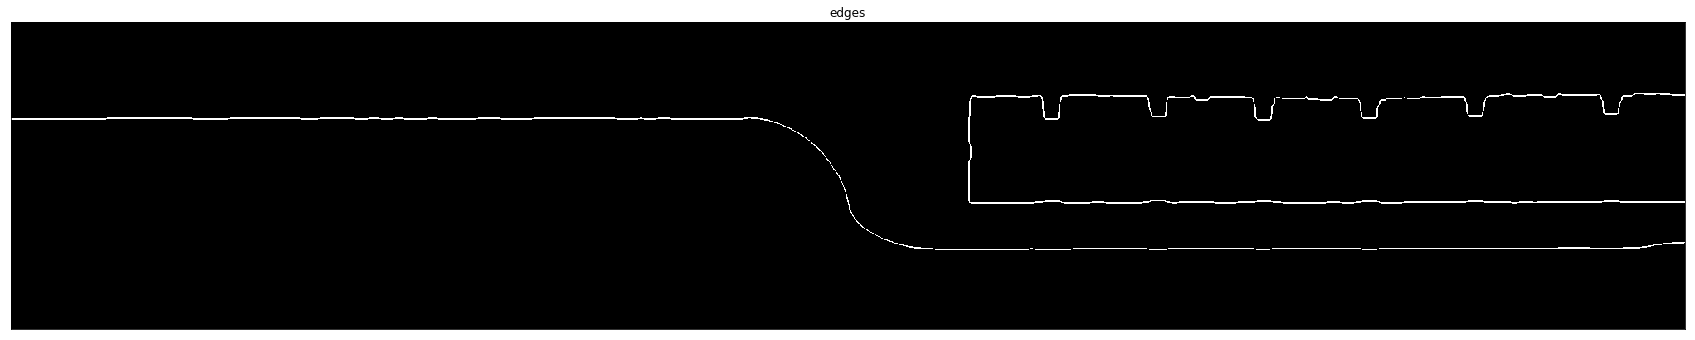

In [143]:
edges = feature.canny(img_bin,sigma=2)
#edges = feature.canny(dark_img_roi,sigma=5)

rows, cols = edges.shape
border = 10
edges_trimmed=edges[border:(rows-2*border),border:(cols-2*border)]

plot_imgs([(edges_trimmed,'edges')], max_cols = 2, fig_size = 30)

3


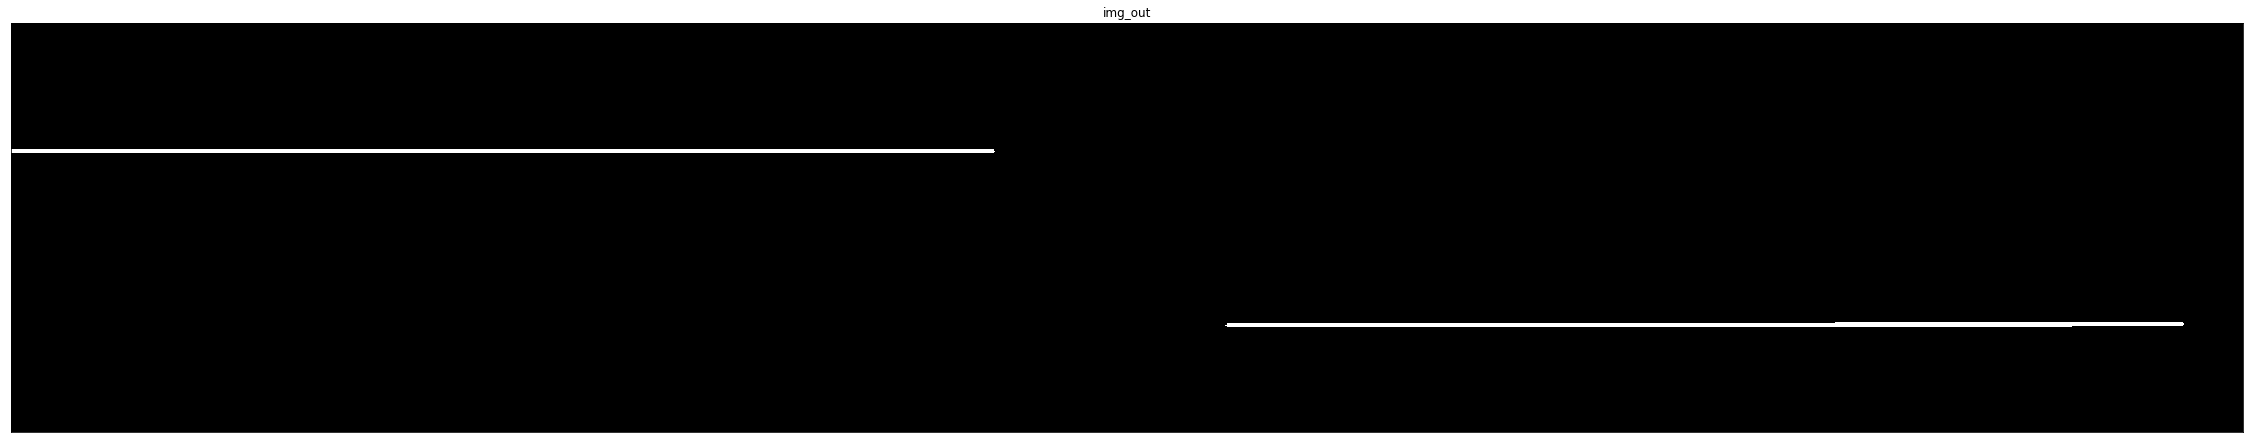

In [145]:
img_out = np.zeros_like(edges_trimmed.astype(np.uint8))

rho = 1
theta = 1*np.pi/180
threshold = 100
minLineLength = 1000
maxLineGap = 300
lines = cv2.HoughLinesP(edges_trimmed.astype(np.uint8),rho,theta,threshold,minLineLength,maxLineGap)
# lines = cv2.HoughLinesP(edges_trimmed.astype(np.uint8),rho=rho, theta=theta, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)
if lines.any():
    numLines = lines.shape[0]
    print(numLines)
    for i in range(numLines):
        x1 = lines[i][0][0]
        y1 = lines[i][0][1]    
        x2 = lines[i][0][2]
        y2 = lines[i][0][3]    
        cv2.line(img_out,(x1,y1),(x2,y2),(255,0,0), 2)
    plot_imgs([(img_out,'img_out')],  fig_size = 40)
else:
    print("No lines found :(")

In [82]:
try_radii = np.arange(75, 100, 2)
res = hough_circle(edges_trimmed, try_radii)
ridx, r, c = np.unravel_index(np.argmax(res), res.shape)
r, c, try_radii[ridx]

(181, 1247, 93)

[0, 2048, 400, 0]

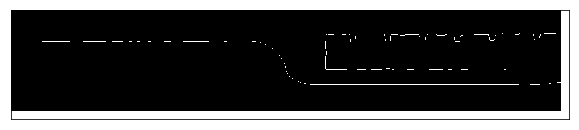

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(edges_trimmed, cmap=plt.cm.gray)

ax.plot(r, c, color='purple', marker='o', markersize='15')
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_bin.shape[1], img_bin.shape[0], 0])

33637


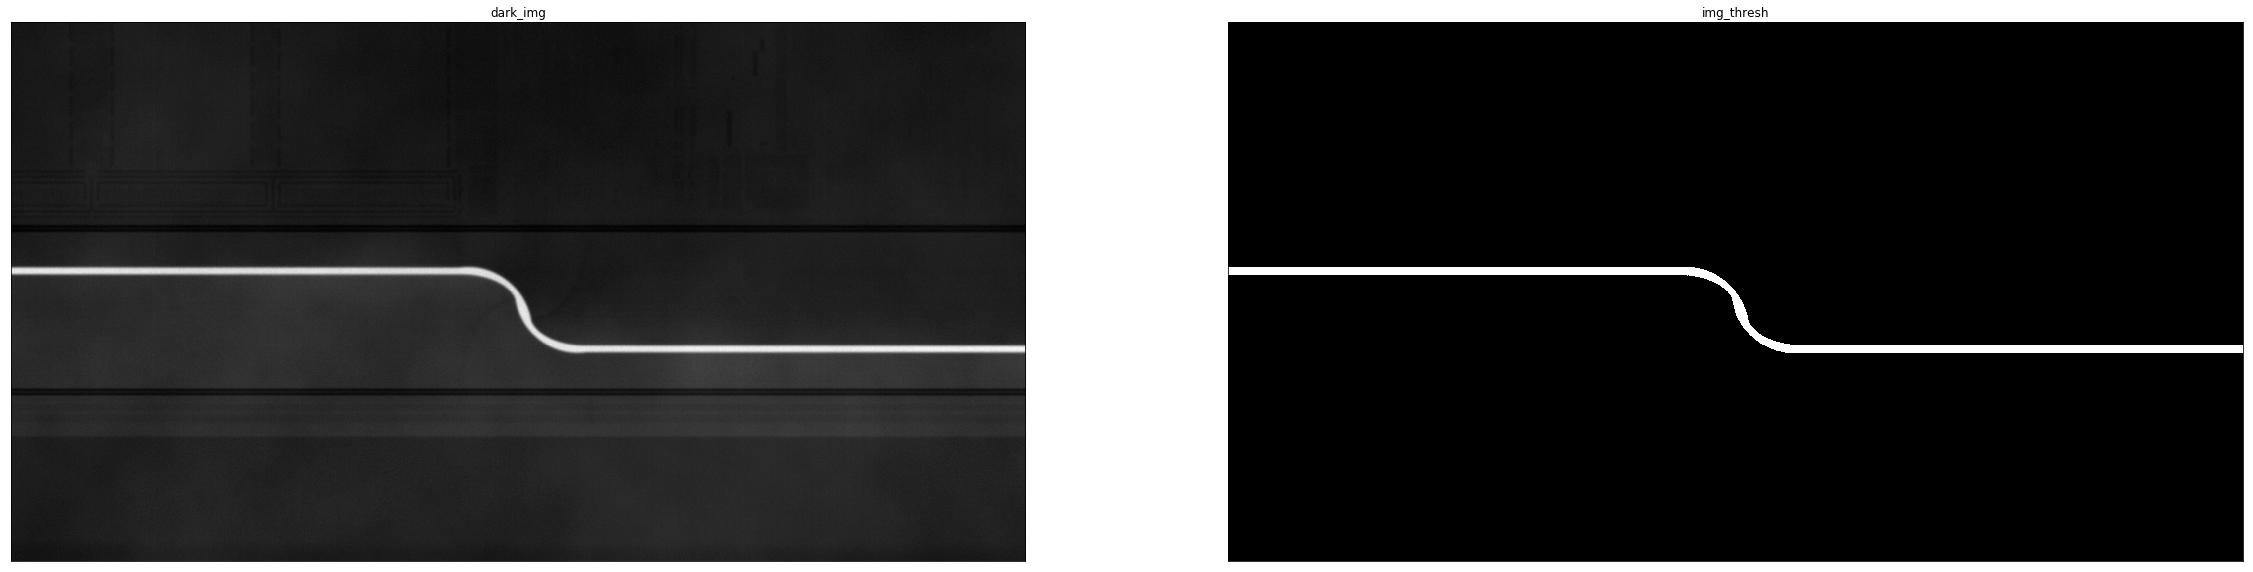

In [94]:
f = '/Users/trafferty/tmp/extrusion_images/request3_bare_bright/A2-IP_OAS-20180514_181050_124515+0900-w1-p1-sna-f2-1r1-2r96376-2048x1088.raw'
raw_rows = 1088
raw_cols = 2048
img = readRaw(f, raw_rows, raw_cols)

img_thresh = img > 100

print(np.count_nonzero(img_thresh))

plot_imgs([(img,'dark_img'), (img_thresh,'img_thresh')], max_cols = 2, fig_size = 20)
